In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


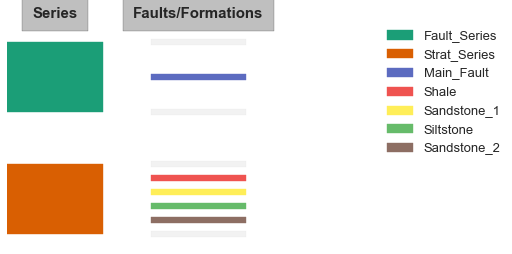

In [2]:
geo_model = gp.create_model('Model_Tuto1-1')

# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0,2000.,0,2000.,0,2000.],[50,50,50], 
      path_o = os.pardir+"/../input_data/tut_chapter1/simple_fault_model_orientations.csv",
      path_i = os.pardir+"/../input_data/tut_chapter1/simple_fault_model_points.csv", default_values=True) 

gp.map_series_to_formations(geo_model, {"Fault_Series":'Main_Fault', 
                         "Strat_Series": ('Sandstone_2','Siltstone',
                                          'Shale', 'Sandstone_1', 'basement')}, remove_unused_series=True)

In [3]:
geo_model.faults.df

,isFault,isFinite
Fault_Series,False,False
Strat_Series,False,False


In [4]:
geo_model.interpolator.theano_graph.inf_factor.get_value()

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [5]:
geo_model.set_is_fault(['Fault_Series'])

              isFault  isFinite
Fault_Series     True     False
Strat_Series    False     False


,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False


In [6]:
geo_model.set_is_finite_fault(["Fault_Series"])

              isFault  isFinite
Fault_Series     True      True
Strat_Series    False     False


In [7]:
geo_model.faults.df

,isFault,isFinite
Fault_Series,True,True
Strat_Series,False,False


In [8]:
geo_model.interpolator.theano_graph.inf_factor.get_value()

array([0])

In [21]:
gp.set_interpolation_data(geo_model,
                              output='geology', compile_theano=True,
                              theano_optimizer='fast_compile',
                              verbose=[])

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


In [22]:
sol = gp.compute_model(geo_model, compute_mesh=False)

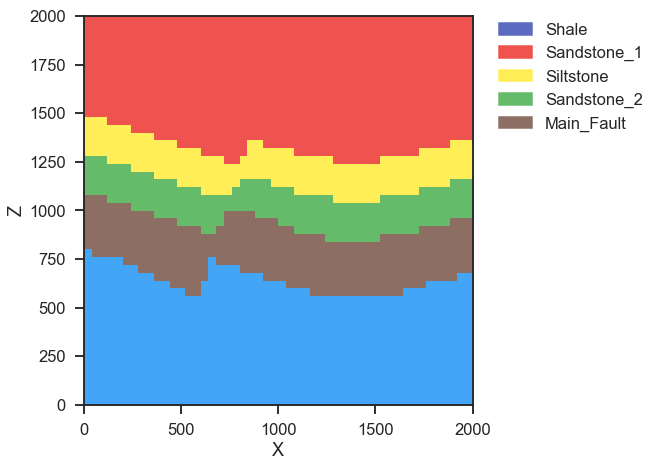

In [25]:
gp.plot.plot_section(geo_model, cell_number=25)

* How to properly set finite fault properties? No methods yet?

In [41]:
geo_model.interpolator.theano_graph.inf_factor.set_value(np.zeros(200, dtype="int32"))

In [45]:
geo_model.faults

,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False
